# Error Analysis

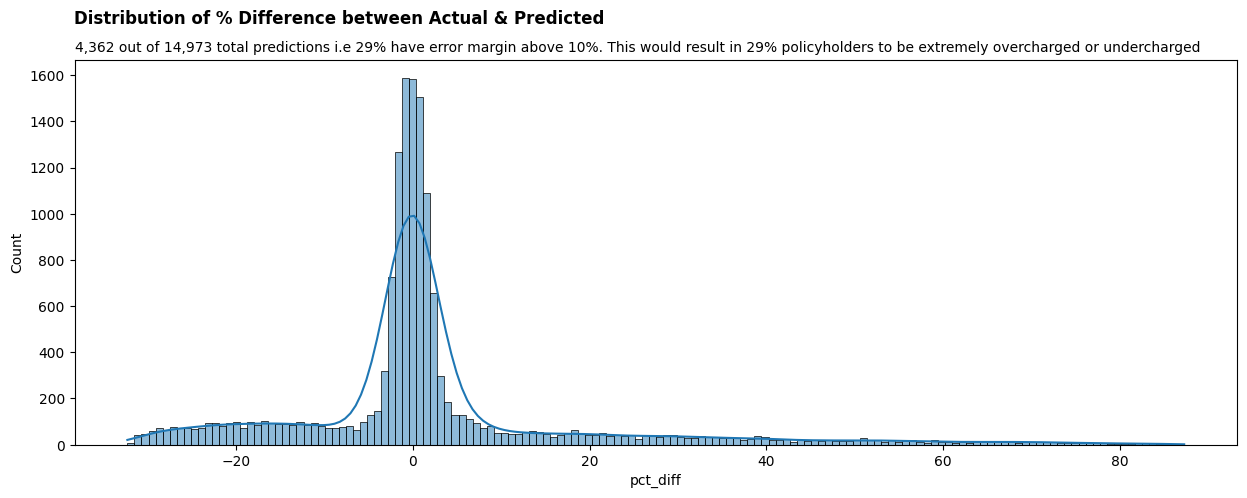

In [6]:
# Importing data science libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import joblib

# Loading processed
df = pd.read_excel('01 Healthcare Premium Prediction/data/processed/processed_premiums_data.xlsx')
df.head()

# Split the data into X (input features) & y (target features)
X = df.drop(columns= ['annual_premium_amount'], axis= 1)
y = df['annual_premium_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 69, shuffle= True)

# Developing XGBoost Regression Model
model = joblib.load(filename= '01 Healthcare Premium Prediction/models/model_overall.joblib')
y_pred = model.predict(X_test)

# Creating a comparision table
results_comparision_df = pd.DataFrame(
    data= {
        'actual': y_test,
        'predicted': y_pred,
        'residuals': (y_pred - y_test),
        'pct_diff': ((y_pred - y_test) / y_test) * 100
    }
)

# Calculating % of extreme errors w.r.t. SoW
extreme_error_threshold = 10
extreme_error_df = results_comparision_df[abs(results_comparision_df['pct_diff']) > extreme_error_threshold ]

total_predictions = results_comparision_df.shape[0]
total_extreme_error_predictions= extreme_error_df.shape[0]

extreme_error_pct = total_extreme_error_predictions / total_predictions * 100

# Visualizing the distribution
plt.figure(figsize= (15,5))
sns.histplot(
    results_comparision_df['pct_diff'],
    kde= True,
    bins= 150
)

plt.suptitle('Distribution of % Difference between Actual & Predicted', ha= 'right', x= 0.478, fontweight= 'bold')
plt.title(
f'{total_extreme_error_predictions:,} out of {total_predictions:,} total predictions i.e {extreme_error_pct:.0f}% have error margin above {extreme_error_threshold}%. ' 
f'This would result in {extreme_error_pct:.0f}% policyholders to be extremely overcharged or undercharged',
x=0.0, ha='left', fontsize=10
)

plt.show()

The histogram reveals that our predicted premium amounts exhibit a high margin of error, with some predictions overshooting actual values by up to ~85%. This implies that certain customers could be overcharged significantly. As agreed during the preparation of SoW, the margin of error was to be kept within 10%.

### Additional: Using ChatGPT for visual beautification

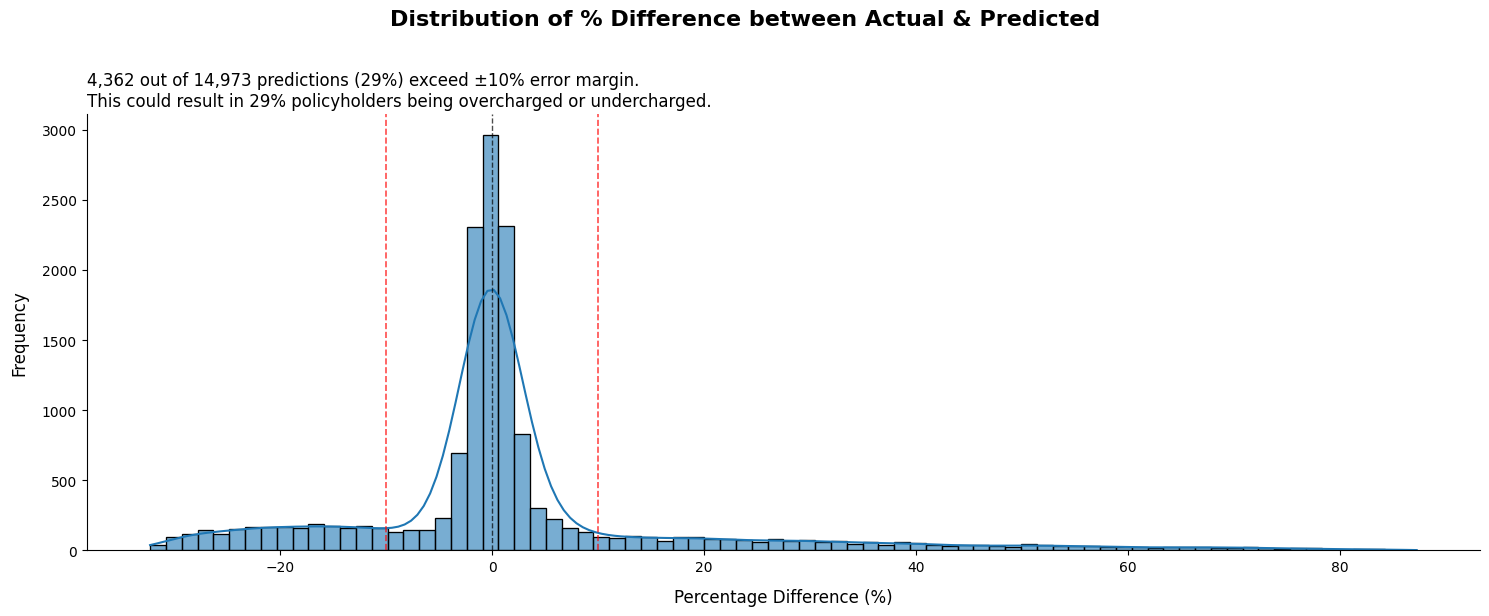

In [7]:
plt.figure(figsize=(15, 6))

# Histogram with KDE
sns.histplot(
    results_comparision_df['pct_diff'],
    kde=True,
    bins=80,
    color="#1f77b4",
    alpha=0.6
)

# Reference lines
plt.axvline(0, color="black", linestyle="--", linewidth=1, alpha=0.7)
plt.axvline(extreme_error_threshold, color="red", linestyle="--", linewidth=1.2, alpha=0.7)
plt.axvline(-extreme_error_threshold, color="red", linestyle="--", linewidth=1.2, alpha=0.7)

# Main title
plt.suptitle(
    "Distribution of % Difference between Actual & Predicted",
    ha="center",
    fontsize=16,
    fontweight="bold",
    y=1.02
)

# Subtitle
plt.title(
    f"{total_extreme_error_predictions:,} out of {total_predictions:,} predictions "
    f"({extreme_error_pct:.0f}%) exceed ±{extreme_error_threshold}% error margin.\n"
    f"This could result in {extreme_error_pct:.0f}% policyholders being overcharged or undercharged.",
    fontsize=12,
    loc="left"
)

# Axis labels
plt.xlabel("Percentage Difference (%)", fontsize=12, labelpad=10)
plt.ylabel("Frequency", fontsize=12, labelpad=10)

# Clean look
sns.despine()
plt.tight_layout()
plt.show()


# Comparing distribution of overall records and extreme error records

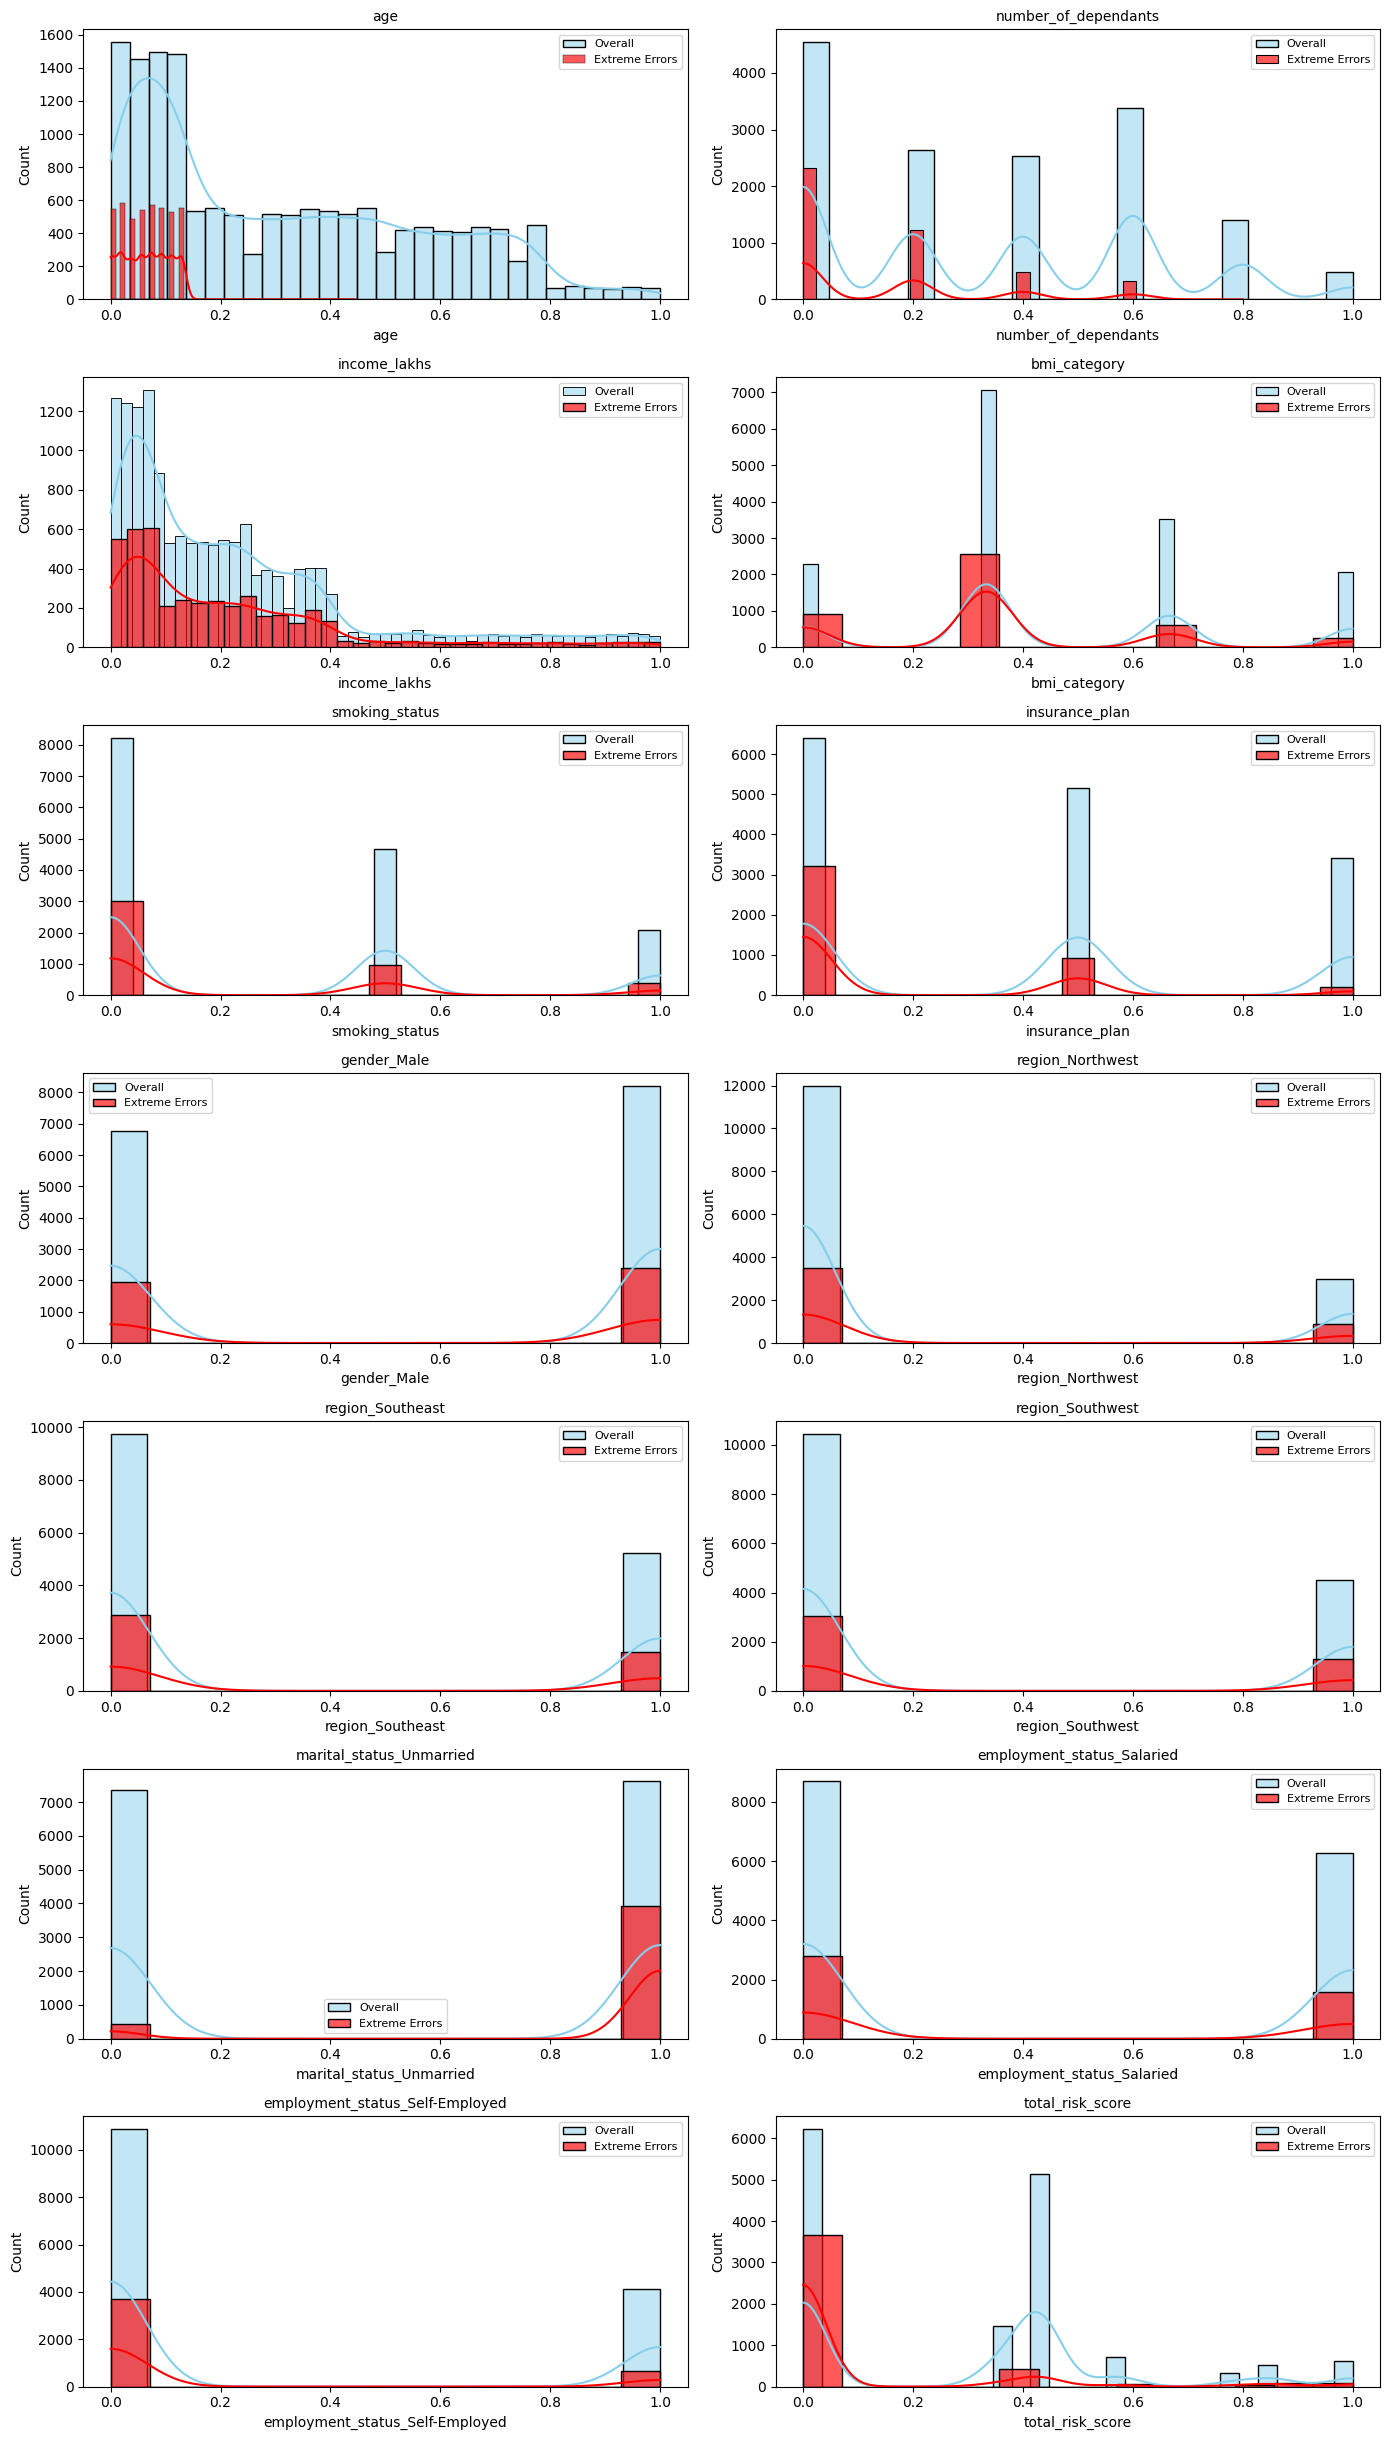

In [8]:
# Segmenting extreme error records from X Test dataframe
extreme_error_records = X_test.loc[extreme_error_df.index]

# Visualizing distribution of normal records and extreme error records
n_features = len(X_test.columns)
n_cols = 2
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 3.5 * n_rows), sharex=False)
axes = axes.flatten()

# Plot each feature
for i, feature in enumerate(X_test.columns):
    ax = axes[i]
    
    sns.histplot(x=X_test[feature], kde=True, color='skyblue', label='Overall', ax=ax)
    sns.histplot(x=extreme_error_records[feature], kde=True, alpha=0.65, color='red', label='Extreme Errors', ax=ax)
    
    ax.set_title(f'{feature}', fontsize=10)
    ax.legend(fontsize=8)
    # ax.tick_params(axis='both', labelsize=8)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


We can observe that 'age' feature has higher frequency of extreme errors towards younger age group.

# Inverse Scaling

In [9]:
# Importing scaler object
scaler_obj = joblib.load('01 Healthcare Premium Prediction/models/scaler_obj_overall.joblib')

# Access scaler
scaler = scaler_obj['scaler']

# Access list of columns scaled
cols_to_scale = scaler_obj['cols_to_scale']

for col in cols_to_scale:
    if col not in extreme_error_records.columns:
        print(f"✅ {col} is going to proxy")
    else:
        print(f"❌ {col} is in cols_to_scale")

❌ age is in cols_to_scale
❌ number_of_dependants is in cols_to_scale
✅ income_level is going to proxy
❌ income_lakhs is in cols_to_scale
❌ bmi_category is in cols_to_scale
❌ smoking_status is in cols_to_scale
❌ insurance_plan is in cols_to_scale
✅ disease1 is going to proxy
✅ disease2 is going to proxy
❌ gender_Male is in cols_to_scale
❌ region_Northwest is in cols_to_scale
❌ region_Southeast is in cols_to_scale
❌ region_Southwest is in cols_to_scale
❌ marital_status_Unmarried is in cols_to_scale
❌ employment_status_Salaried is in cols_to_scale
❌ employment_status_Self-Employed is in cols_to_scale
❌ total_risk_score is in cols_to_scale


count    4362.000000
mean       21.521320
std         2.370833
min        18.000000
25%        19.000000
50%        22.000000
75%        23.000000
max        42.000000
Name: age, dtype: float64


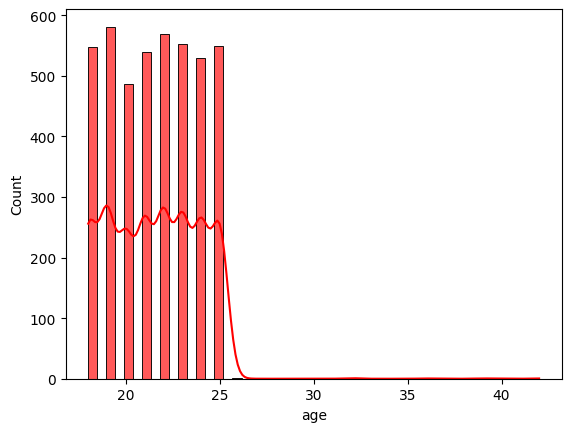

In [10]:
# Creating proxy columns for reverse scaling
proxy = extreme_error_records.copy()
proxy[['income_level','disease1', 'disease2']] = -1

df_inversed = pd.DataFrame()
df_inversed[cols_to_scale] = scaler.inverse_transform(proxy[cols_to_scale])

print(df_inversed['age'].describe())
sns.histplot(x=df_inversed['age'], kde=True, alpha=0.65, color='red', label='Extreme Errors')
plt.show()

From histogram we can identify, majority errors are contributed by younger age group between 18 to 25.

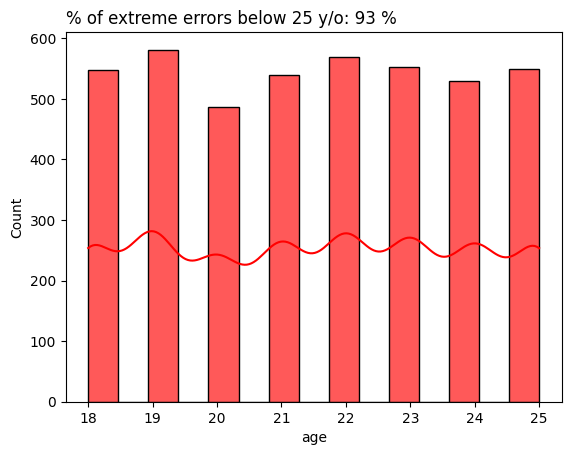

In [11]:
from scipy.stats import norm
pct_below_25 = norm.cdf(
    25,
    df_inversed['age'].mean(),
    df_inversed['age'].std()
)

sns.histplot(x=df_inversed[df_inversed['age'] <=25]['age'], kde=True, alpha=0.65, color='red', label='Extreme Errors')
plt.title(f'% of extreme errors below 25 y/o: {pct_below_25*100:.0f} %', loc= 'left', fontsize= 12)
plt.show()

# Model Segmentation

Since, our main model has higher error margin for younger age group (18-25), around 93%, we can segment our model. This technique is known as Model Segmentation:
- Model A -> Younger age group (18-25)
- Model B -> Rest of the age groups

However, the remaining 7% will be moved to Model B, this might as well reduce their margin of error.